# Exploratory Analysis - Worst State Drivers

This notebook looks at moving violations in DC to see which state's drivers rack up the most.

## Import libraries

In [163]:
##Import Libraries
import psycopg2 #PostgreSQL driver
import datetime
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas.io.sql as psql
import geopandas as gpd
import SQL_cred
from collections import Counter
from IPython.display import Markdown as md


## Load data from database or from file

In [61]:
#Set SQL Address, Create SQL import function 'load_data'
conn_string = "host="+ SQL_cred.PGHOST +" port="+ "5432" +" dbname="+ SQL_cred.PGDATABASE +" user=" + SQL_cred.PGUSER \
+" password="+ SQL_cred.PGPASSWORD

def load_data(query):

    sql_command = query
    print (sql_command)

    # Load the data
    data = pd.read_sql(sql_command, conn)

    print(data.shape)
    return (data)

In [62]:
conn=psycopg2.connect(conn_string)
query="SELECT issue_date,latitude, longitude,fine_amount, violation_code, violation_process_desc,plate_state, objectid FROM analysis_data.moving_violations"
cursor = conn.cursor() # is this necessary?
if not os.path.exists('worst-state.csv'):
    df=load_data(query)
    df.to_csv('worst-state.csv')


True


In [130]:
mv=pd.read_csv('worst-state.csv',index_col=0,parse_dates=['issue_date'])
mv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11301604 entries, 0 to 11301603
Data columns (total 8 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   issue_date              datetime64[ns]
 1   latitude                float64       
 2   longitude               float64       
 3   fine_amount             float64       
 4   violation_code          object        
 5   violation_process_desc  object        
 6   plate_state             object        
 7   objectid                int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 776.0+ MB


In [166]:
states = ['DC', 'MD', 'VA']
mv_by_year_state_violation = mv[mv['plate_state'].isin(states)].groupby(
    [mv['issue_date'].dt.year, 'plate_state', 'violation_process_desc']).count()['objectid'].reset_index()
mv_by_year_state_violation = mv_by_year_state_violation.rename(
    columns={'plate_state': 'state', 'issue_date': 'year', 'objectid': 'violation_count', 'violation_process_desc': 'violation'})
first_year = mv_by_year_state_violation.year.min()
last_year = mv_by_year_state_violation.year.max()


## Which state had the most violations year over year?

In [194]:
sums_all_years = mv_by_year_state_violation.groupby(
    ['state']).sum()['violation_count'].to_frame().reset_index()

state_with_most = sums_all_years[sums_all_years.violation_count == sums_all_years.violation_count.max()]
md("**{state}** drivers have the most violations from {first_year} to {last_year}: {number}".format(
    state=state_with_most.iloc[0]['state'], first_year=first_year, last_year=last_year, number=format(state_with_most.iloc[0]['violation_count'], ',')))

**MD** drivers have the most violations from 2010 to 2021: 328,969

<AxesSubplot:xlabel='year'>

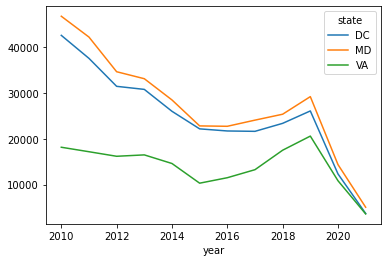

In [195]:
mv_by_state_year = mv_by_year_state_violation.groupby(
    ['state', 'year']).sum()['violation_count'].reset_index()
pv_by_state_year = mv_by_state_year.pivot(
    columns="state", index="year").reset_index()
pv_by_state_year.plot(x="year", y="violation_count")


## Which state had the most violations in five years?

In [197]:
sums_5_years = mv_by_year_state_violation[mv_by_year_state_violation['year'] > last_year - 5].groupby(
    ['state']).sum()['violation_count'].to_frame().reset_index()

state_with_most_5_year = sums_5_years[sums_5_years.violation_count ==
                                 sums_5_years.violation_count.max()]
md("**{state}** drivers have the most violations from {first_year} to {last_year}: {number}".format(
    state=state_with_most_5_year.iloc[0]['state'], first_year=last_year - 5, last_year=last_year, number=format(state_with_most_5_year.iloc[0]['violation_count'], ',')))


**MD** drivers have the most violations from 2016 to 2021: 98,133

<AxesSubplot:xlabel='year'>

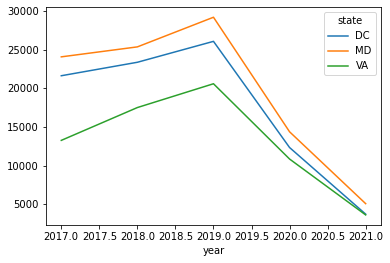

In [199]:
pv_by_state_year[pv_by_state_year.year > last_year - 5].plot(x="year", y="violation_count")


## What was the most common violation for each state?

In [262]:
mv_state_violation = mv_by_year_state_violation.groupby(['state','violation']).sum()['violation_count'].reset_index()
mv_state_violation.groupby(['state'])['violation_count'].max()
idx = mv_state_violation.groupby(['state'])['violation_count'].transform(max) == mv_state_violation['violation_count']
outputList = ["The most common violation for **{state}** drivers was **{violation}**.".format(
    state=state, violation=mv_state_violation[idx].set_index('state').loc[state]['violation']) for state in states]
md('\n\n'.join(outputList))


The most common violation for **DC** drivers was **PASSING STOP SIGN WITHOUT COMING TO A FULL STOP**.

The most common violation for **MD** drivers was **FAIL TO DISPLAY PROOF OF VEHICLE INSURANCE**.

The most common violation for **VA** drivers was **FAIL TO DISPLAY PROOF OF VEHICLE INSURANCE**.